# Forcasting  

In this notebook we will predict the closing prices for the next month

In [45]:
# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

In [46]:

# Load the dataset
data = pd.read_csv('./data/cleaned_weekly_stock_market.csv')


In [47]:

# Extract rows for specified companies
companies = ['AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE', 'EURO-CYCLES',
             'SOTUMAG', 'ONE TECH', 'TUNINDEX', 'SAH', 'SFBT', 'SOMOCER', 'SOTETEL',
             'SOTUVER', 'TUNISAIR', 'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB']

tunindex = data[data['companyName'] == 'TUNINDEX']
amenbank = data[data['companyName'] == 'AMEN BANK']
data_filtered = data[data['companyName'].isin(companies)]


In [49]:
def str_to_datetime(s):
    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except ValueError:
        return datetime.strptime(s, '%d/%m/%Y')

In [48]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert string dates to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []
    last_time = False

    while not last_time:
        # Select the subset of data up to and including the target date
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        # Extract closing prices as features (X) and target (Y)
        values = df_subset['closingPrice'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Attempt to move to the next date within a week
        next_week = dataframe.loc[target_date + timedelta(days=1):target_date + timedelta(days=7)]
        if not next_week.empty:
            next_date = next_week.index[0]
        else:
            print("No more data available for the next week.")
            break

        # Update target_date
        target_date = next_date

        # Check if the process should terminate
        if target_date >= last_date:
            last_time = True

    # Prepare the return DataFrame
    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]
    ret_df['Target'] = Y

    return ret_df


In [50]:

def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)
    y = df_as_np[:, -1]
    return dates, X.astype(np.float32), y.astype(np.float32)


In [51]:
def train_and_plot_model(data, company_name):
    try:
        print(f"Starting process for {company_name}...")
        n = 3 
        df = data[['date', 'closingPrice']]
        df['date'] = df['date'].apply(str_to_datetime) 
        df.index = df.pop('date')
        
        first_valid_date = df.index[n]
        last_date = df.index[-1]
        windowed_df = df_to_windowed_df(df, first_valid_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d'), n=n)
        
        if windowed_df is None:
            print("Windowed dataframe is None, exiting...")
            return

        dates, X, y = windowed_df_to_date_X_y(windowed_df)

        print("Splitting data into train, validation, and test sets...")
        X_train_val, X_test, y_train_val, y_test, dates_train_val, dates_test = train_test_split(
            X, y, dates, test_size=0.2, random_state=42
        )

        X_train, X_val, y_train, y_val, dates_train, dates_val = train_test_split(
            X_train_val, y_train_val, dates_train_val, test_size=0.25, random_state=42
        )

        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, y_train, label='Train')
        plt.plot(dates_val, y_val, label='Validation')
        plt.plot(dates_test, y_test, label='Test')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Train, Validation, and Test Data for {company_name}')
        plt.show()

        model = Sequential([layers.Input(shape=(n, 1)),
                            layers.LSTM(64),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(1)])
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['mean_absolute_error'])
        model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

        train_pred = model.predict(X_train).flatten()
        val_pred = model.predict(X_val).flatten()
        test_pred = model.predict(X_test).flatten()

        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, train_pred)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_pred)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_pred)
        plt.plot(dates_test, y_test)
        plt.legend(['Training Prediction', 'Training Observation',
                    'Validation Prediction', 'Validation Observation',
                    'Test Prediction', 'Test Observation'])
        plt.title(f'Predictions and Observations for {company_name}')
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:

# Apply the model for each company
for company in companies:
    company_data = data_filtered[data_filtered['companyName'] == company]
    if not company_data.empty:
        print(f'Training and plotting for {company}')
        train_and_plot_model(company_data, company)
    else:
        print(f'No data available for {company}')


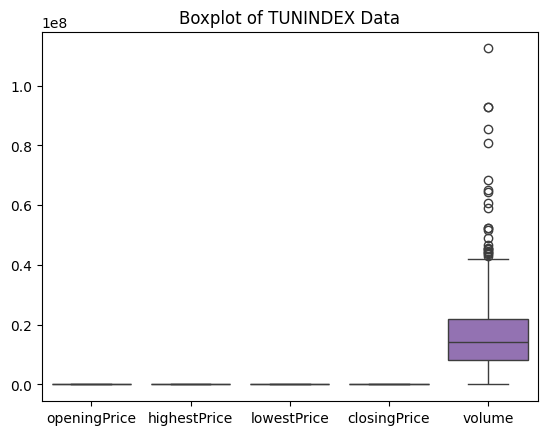

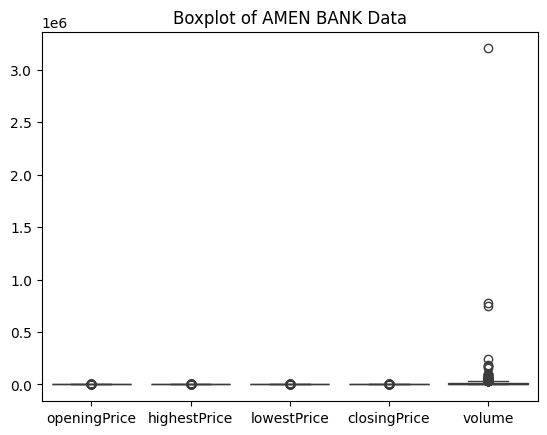

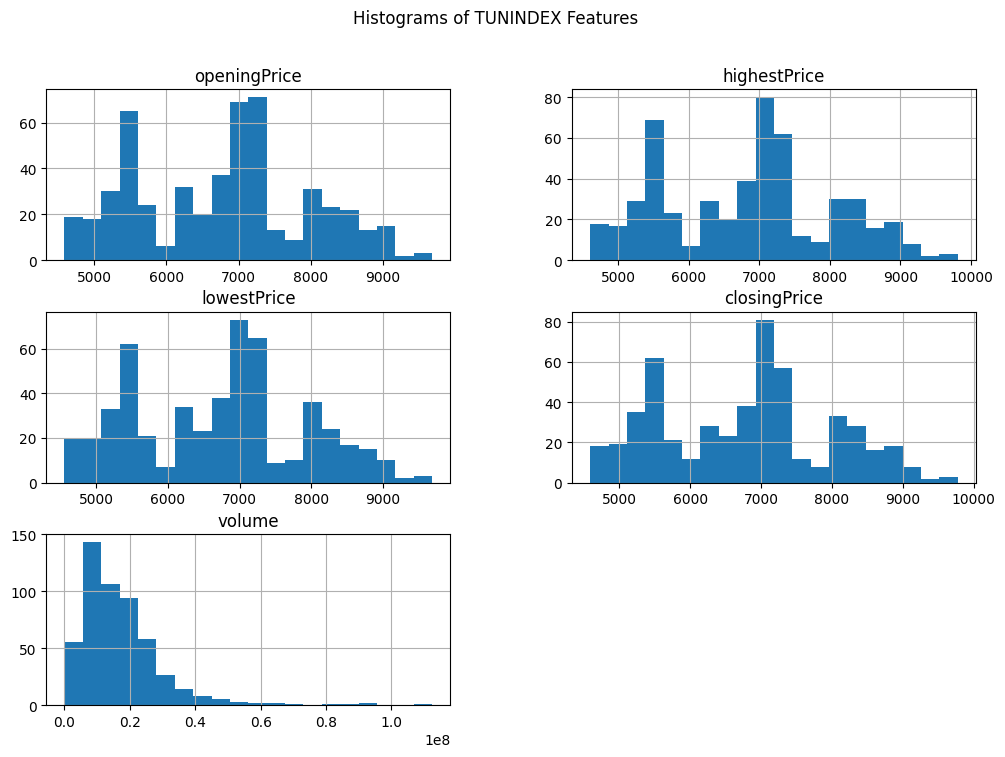

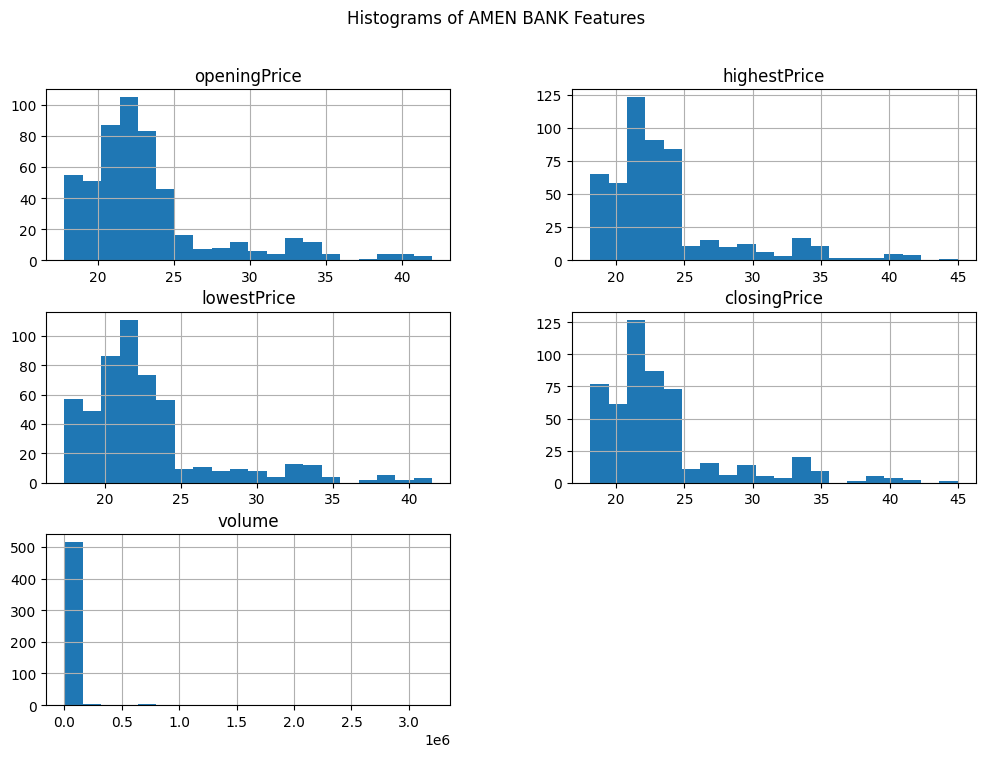

In [53]:

# Boxplot for visualizing outliers
sns.boxplot(data=tunindex)
plt.title('Boxplot of TUNINDEX Data')
plt.show()

# Boxplot for visualizing outliers
sns.boxplot(data=amenbank)
plt.title('Boxplot of AMEN BANK Data')
plt.show()

# Histograms for distribution
tunindex.hist(figsize=(12, 8), bins=20)
plt.suptitle('Histograms of TUNINDEX Features')
plt.show()

# Histograms for distribution
amenbank.hist(figsize=(12, 8), bins=20)
plt.suptitle('Histograms of AMEN BANK Features')
plt.show()


In [64]:
# Log transformation
tunindex_transformed = tunindex.copy()
tunindex_transformed['volume'] = np.log(tunindex_transformed['volume'] + 1)

# Removing outliers
z_scores = np.abs(stats.zscore(tunindex_transformed[['volume']]))
tunindex_no_outliers = tunindex[(z_scores < 3).all(axis=1)]

# Scaling
tunindex_scaled = tunindex.copy()
scaler = StandardScaler()
tunindex_scaled['volume'] = scaler.fit_transform(tunindex_scaled[['volume']])

Starting process for TUNINDEX...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11932\3524853662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


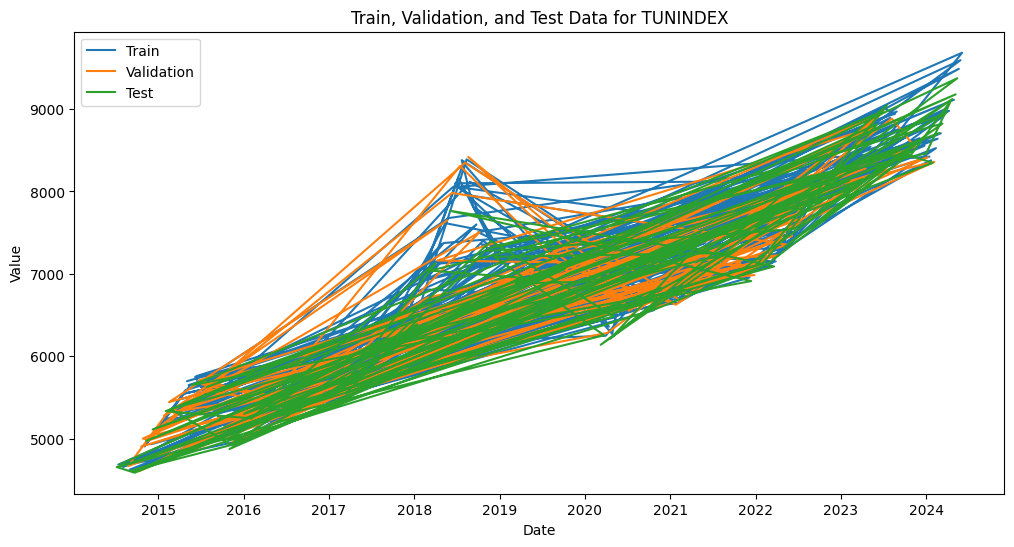

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 48103464.0000 - mean_absolute_error: 6843.9980 - val_loss: 45555520.0000 - val_mean_absolute_error: 6649.8770
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47991448.0000 - mean_absolute_error: 6830.4722 - val_loss: 45543088.0000 - val_mean_absolute_error: 6648.9419
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 48493328.0000 - mean_absolute_error: 6877.4224 - val_loss: 45526244.0000 - val_mean_absolute_error: 6647.6748
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 48518204.0000 - mean_absolute_error: 6871.7666 - val_loss: 45503928.0000 - val_mean_absolute_error: 6645.9956
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 48979296.0000 - mean_absolute_error: 6909.7646 - val_loss: 45473628.0000 - val_mean_absolute_error: 6643.7163
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 47521848.0000 - mean_absolute_error: 6799.4429 - val_loss: 45433728.0000 - val_mean_absolute_er

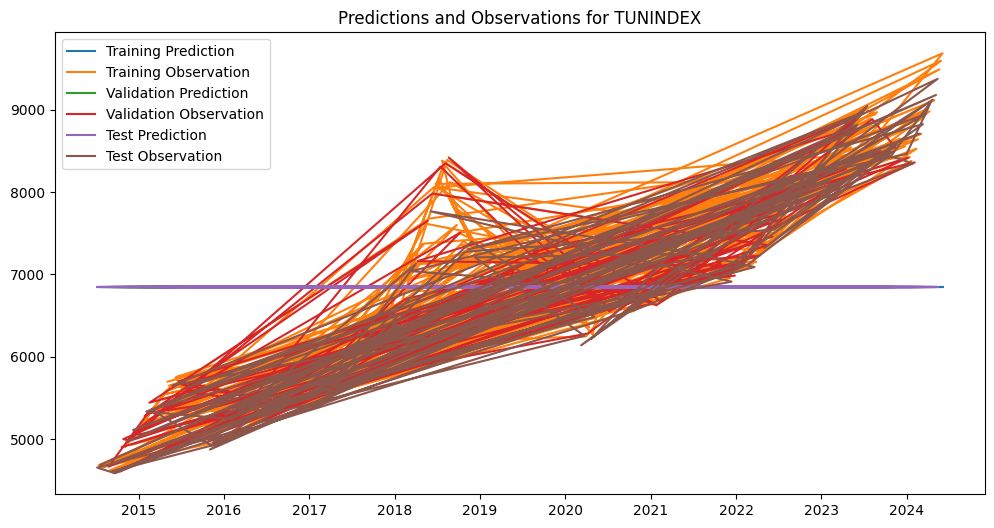

Starting process for TUNINDEX...
No more data available for the next week.
Splitting data into train, validation, and test sets...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11932\3524853662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


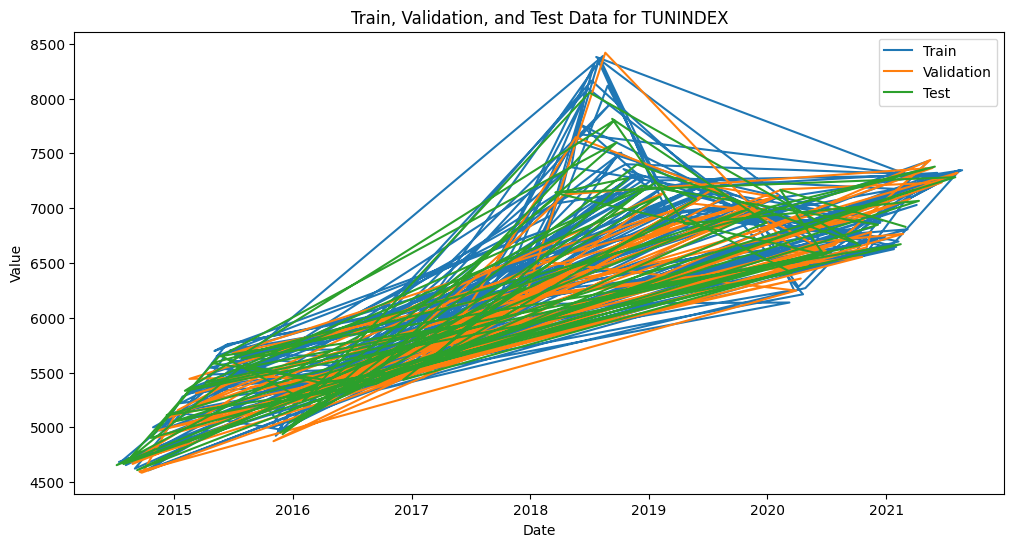

Epoch 1/100


In [65]:
train_and_plot_model(tunindex_scaled, 'TUNINDEX')

train_and_plot_model(tunindex_no_outliers, 'TUNINDEX')

train_and_plot_model(tunindex_transformed, 'TUNINDEX')